In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_30_sec.csv
/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_3_sec.csv
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/hiphop/hiphop00037.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/hiphop/hiphop00076.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/hiphop/hiphop00049.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/hiphop/hiphop00001.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/hiphop/hiphop00056.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/hiphop/hiphop00008.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/hiphop/hiphop00011.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/hiphop/hiphop00029.png
/kaggle/input/gtzan-dataset-music-genre-classific

/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/metal/metal.00003.wav
/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/metal/metal.00042.wav
/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/metal/metal.00098.wav
/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/metal/metal.00015.wav
/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/metal/metal.00073.wav
/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/metal/metal.00079.wav
/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/metal/metal.00011.wav
/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/metal/metal.00094.wav
/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/metal/metal.00013.wav
/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/metal/metal.00037.wav
/kaggle/input/gtzan-

## Load wav file

In [5]:
wav_path = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00000.wav'

In [6]:
import librosa

y, sr = librosa.load(wav_path, sr=None)
print(y.shape)
print(f'{sr}Hz')

(661794,)
22050Hz


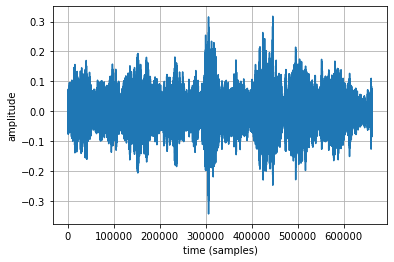

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(y)
plt.xlabel('time (samples)')
plt.ylabel('amplitude')
plt.grid()

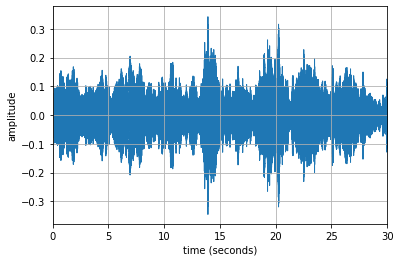

In [8]:
import librosa.display

librosa.display.waveplot(y, sr=sr)
plt.xlabel('time (seconds)')
plt.ylabel('amplitude')
plt.grid()

## Play audio file

In [9]:
from IPython.display import Audio, display

display(Audio(data=y, rate=sr))

## Display a log spectrogram

In [10]:
n_fft = 2048
hop_length = 512

(1025, 1293)


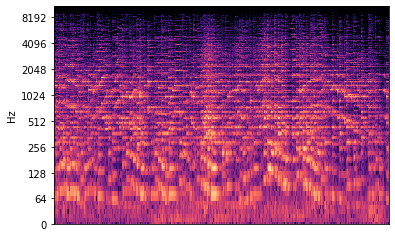

In [11]:
spectrogram = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
log_spectrogram = librosa.amplitude_to_db(np.abs(spectrogram), ref=np.max)
print(log_spectrogram.shape)
librosa.display.specshow(log_spectrogram, y_axis='log');

## Calculate MFCC with librosa

In [12]:
n_mfcc = 13

mfcc = librosa.feature.mfcc(y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc)
print(mfcc.shape)

(13, 1293)


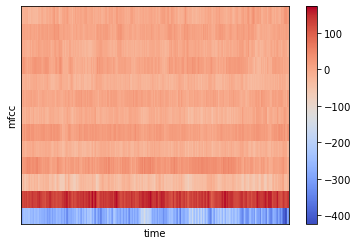

In [13]:
librosa.display.specshow(mfcc, sr=sr, hop_length=hop_length)
plt.xlabel('time')
plt.ylabel('mfcc')
plt.colorbar();

## Split to Train / Valid / Test

In [14]:
data_dir = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original'
genre_list = sorted(os.listdir(data_dir))
print(genre_list)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [15]:
import glob
import random

# create all dataset list
wav_files = []

for wav_path in glob.glob(os.path.join(data_dir, '*', '*.wav')):
    # broken file
    if 'jazz.00054.wav' in wav_path:
        continue
    wav_files.append(wav_path)

random.shuffle(wav_files)
print(len(wav_files))

999


In [16]:
wav_files[0:3]

['/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/pop/pop.00013.wav',
 '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00002.wav',
 '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00084.wav']

In [17]:
# split to train/test
num_test_size = 10
test_files = wav_files[:num_test_size]
train_files = wav_files[num_test_size:]

# split to train/valid
num_valid_size = 50
valid_files = train_files[:num_valid_size]
train_files = train_files[num_valid_size:]

In [18]:
print(len(train_files), len(valid_files), len(test_files))

939 50 10


## Extract MFCC features

In [19]:
sample_rate = 22050
n_mfcc = 13
n_fft = 2048
hop_length = 512

In [20]:
duration = 30
num_segments = 10

samples_per_track = sample_rate * duration
num_samples_per_segment = int(samples_per_track / num_segments)

def extract_mfcc(wav_files, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    for wav_path in wav_files:
        prefix = wav_path.split('/')[-1].replace('.wav', '')

        y, sr = librosa.load(wav_path, sr=None)

        for s in range(num_segments):
            start = s * num_samples_per_segment
            end = start + num_samples_per_segment

            # (mfcc_dim, frame)
            mfcc = librosa.feature.mfcc(y[start:end],
                                        sr=sample_rate,
                                        n_fft=n_fft,
                                        n_mfcc=n_mfcc,
                                        hop_length=hop_length)
            # (frame, mfcc_dim)
            mfcc = mfcc.T

            if mfcc.shape[0] != 130:
                print('WARNING: invalid mfcc size: {}_{} {}'.format(prefix, s, mfcc.shape))
                continue

            # save mfcc
            mfcc_path = os.path.join(output_dir, prefix + '_{}.npy'.format(s))
            np.save(mfcc_path, mfcc)

In [21]:
extract_mfcc(train_files, '/kaggle/working/train')
extract_mfcc(valid_files, '/kaggle/working/valid')
extract_mfcc(test_files, '/kaggle/working/test')

In [22]:
ls -1 train | wc -l

9386


In [23]:
ls -1 valid | wc -l

500


In [24]:
ls -1 test | wc -l

100


## PyTorch Dataset

In [25]:
print(genre_list)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [181]:
import torch
import torch.nn.functional as F


class AudioDataset(torch.utils.data.Dataset):

    def __init__(self, mfcc_files):
        self.mfcc_files = mfcc_files
        self.sample_rate = sample_rate

    def __getitem__(self, index):
        mfcc_path = self.mfcc_files[index]
        mfcc = np.load(mfcc_path)
        mfcc = torch.from_numpy(mfcc)

        # get ground truth label
        genre = mfcc_path.split('/')[-1].split('.')[0]
        label = genre_list.index(genre)

        return mfcc, label

    def __len__(self):
        return len(self.mfcc_files)

In [182]:
import glob

train_files = sorted(glob.glob('/kaggle/working/train/*.npy'))
valid_files = sorted(glob.glob('/kaggle/working/valid/*.npy'))
test_files = sorted(glob.glob('/kaggle/working/test/*.npy'))

print(train_files[:3])

['/kaggle/working/train/blues.00000_0.npy', '/kaggle/working/train/blues.00000_1.npy', '/kaggle/working/train/blues.00000_2.npy']


In [183]:
train_dataset = AudioDataset(train_files)
valid_dataset = AudioDataset(valid_files)
test_dataset = AudioDataset(test_files)

In [184]:
len(train_dataset), len(valid_dataset), len(test_dataset)

(9386, 500, 100)

In [185]:
mfcc, label = train_dataset[0]
print(mfcc.shape)
print(label)

torch.Size([130, 13])
0


## PyTorch DataLoader

In [186]:
batch_size = 32

In [187]:
import torch.utils.data

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size,
    shuffle=True,
    num_workers=8,
    pin_memory=True)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size,
    shuffle=False,
    num_workers=8,
    pin_memory=True)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size,
    shuffle=False,
    num_workers=8,
    pin_memory=True)

In [188]:
x, y = iter(train_loader).next()
print(x.shape)  # mfcc
print(y.shape)  # genre label

torch.Size([32, 130, 13])
torch.Size([32])


## Multi-layer perceptron model

In [199]:
import torch.nn as nn


class MultiLayerPerceptron(nn.Module):
    
    def __init__(self, input_shape=(13, 130)):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape[0] * input_shape[1], 512),
            nn.ReLU(),
            nn.Dropout(),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(),

            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(),

            nn.Linear(64, 10)
        )
    
    def forward(self, mfcc):
        output = self.model(mfcc)
        return output

In [200]:
# Test model
model = MultiLayerPerceptron()
batch = iter(train_loader).next()
x, y = batch
output = model(x)
print(output.shape)

torch.Size([32, 10])


## Training

In [201]:
import torch
import torch.nn as nn
import torch.optim as optim


device = torch.device('cuda:0')
print(device)

cuda:0


In [203]:
def train(train_loader, model, criterion, optimizer):
    model.train()
    
    running_loss = 0.0
    correct = 0
    total = 0

    for batch in train_loader:
        mfcc, labels = batch
        mfcc, labels = mfcc.to(device), labels.to(device)

        optimizer.zero_grad()

        y_hat = model(mfcc)

        loss = criterion(y_hat, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # accuracy
        _, predicted = torch.max(y_hat.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    return train_loss, train_acc

In [204]:
def valid(valid_loader, model, criterion):
    model.eval()
    
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in valid_loader:
            mfcc, labels = batch
            mfcc, labels = mfcc.to(device), labels.to(device)
            y_hat = model(mfcc)
            loss = criterion(y_hat, labels)
            running_loss += loss.item()
    
            # accuracy
            _, predicted = torch.max(y_hat.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    valid_loss = running_loss / len(valid_loader)
    valid_acc = correct / total

    return valid_loss, valid_acc

In [210]:
from collections import defaultdict

model = MultiLayerPerceptron().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# training loop
max_epochs = 50

history = defaultdict(list)

for epoch in range(1, max_epochs + 1):
    train_loss, train_acc = train(train_loader, model, criterion, optimizer)
    valid_loss, valid_acc = valid(valid_loader, model, criterion)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['valid_loss'].append(valid_loss)
    history['valid_acc'].append(valid_acc)

    print('Epoch [{}/{}] train_loss: {:.3f} valid_loss: {:.3f} train_acc: {:.3f} valid_acc: {:.3f}'.format(epoch, max_epochs, train_loss, valid_loss, train_acc, valid_acc))

Epoch [1/50] train_loss: 2.706 valid_loss: 2.159 train_acc: 0.110 valid_acc: 0.226
Epoch [2/50] train_loss: 2.239 valid_loss: 2.104 train_acc: 0.138 valid_acc: 0.222
Epoch [3/50] train_loss: 2.189 valid_loss: 2.017 train_acc: 0.183 valid_acc: 0.308
Epoch [4/50] train_loss: 2.146 valid_loss: 1.941 train_acc: 0.201 valid_acc: 0.310
Epoch [5/50] train_loss: 2.129 valid_loss: 1.902 train_acc: 0.209 valid_acc: 0.328
Epoch [6/50] train_loss: 2.044 valid_loss: 1.882 train_acc: 0.238 valid_acc: 0.324
Epoch [7/50] train_loss: 2.013 valid_loss: 1.820 train_acc: 0.239 valid_acc: 0.350
Epoch [8/50] train_loss: 1.998 valid_loss: 1.851 train_acc: 0.243 valid_acc: 0.316
Epoch [9/50] train_loss: 1.979 valid_loss: 1.885 train_acc: 0.247 valid_acc: 0.298
Epoch [10/50] train_loss: 1.957 valid_loss: 1.848 train_acc: 0.265 valid_acc: 0.328
Epoch [11/50] train_loss: 1.938 valid_loss: 1.822 train_acc: 0.274 valid_acc: 0.310
Epoch [12/50] train_loss: 1.927 valid_loss: 1.774 train_acc: 0.275 valid_acc: 0.374
E

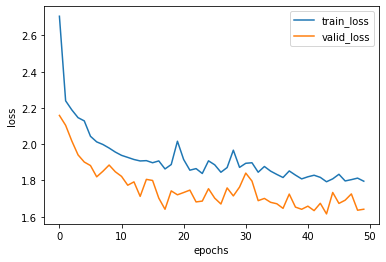

In [214]:
import matplotlib.pyplot as plt

plt.plot(range(max_epochs), history['train_loss'], label='train_loss')
plt.plot(range(max_epochs), history['valid_loss'], label='valid_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show();

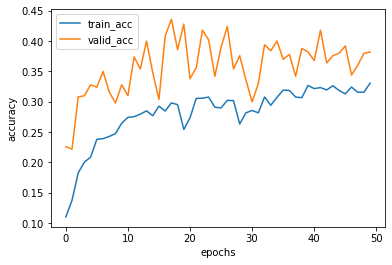

In [215]:
plt.plot(range(max_epochs), history['train_acc'], label='train_acc')
plt.plot(range(max_epochs), history['valid_acc'], label='valid_acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show();